# Stage 2: Model training

In [1]:
import anndata
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
from matplotlib import rcParams

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Read preprocessed data

First, read the preprocessed data as produced by [stage 1](preprocessing.ipynb).

In [3]:
rna = anndata.read_h5ad("rna_preprocessed.h5ad")
atac = anndata.read_h5ad("atac_preprocessed.h5ad")
graph = nx.read_graphml("prior.graphml.gz")

## Configure data

> (Estimated time: negligible)

Before model training, we need to configure the datasets using [scglue.models.configure_dataset](api/scglue.models.scglue.configure_dataset.rst). For each dataset to be integrated, we specify the probabilistic generative model to use. Here we model the raw counts of both scRNA-seq and scATAC-seq using the negative binomial distribution (`"NB"`).

Optionally, we can specify whether only the highly variable features should be used (`use_highly_variable`), what data layer to use (`use_layer`), as well as what preprocessing embedding (`use_rep`) to use as first encoder transformation.

* For the scRNA-seq data, we use the [previously backed up](preprocessing.ipynb#Preprocess-scRNA-seq-data) raw counts in the "raw" layer, and use the PCA embedding as the first encoder transformation.
* For the scATAC-seq data, the raw counts are just `atac.X`, so it's unnecessary to specify `use_layer`. We use the LSI embedding as the first encoder transformation.

In [4]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="raw", use_rep="X_pca"
)

In [5]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

Accordingly, we also subset the prior graph to retain highly variable features only.

In [6]:
graph = graph.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

## Build and train GLUE model

> (Estimated time: 5-30 min, depending on computation device)

Next we initialize a [GLUE model](api/scglue.models.scglue.SCGLUEModel.rst) for integrating the two omics layers.

* The datasets to be integrated as specified as a `dict`, where the keys are domain names. The domain names can be set at your discretion, as long as they are kept consistent (see below).
* The graph nodes are specified as a list. Here we use a sorted list to guarantee a consistent order.

In [7]:
glue = scglue.models.SCGLUEModel(
    {"rna": rna, "atac": atac}, sorted(graph.nodes),
    random_seed=0
)

[INFO] autodevice: Using GPU 6 as computation device.


To prepare the model for training, we ["compile"](api/scglue.models.scglue.SCGLUEModel.compile.rst) it to initialize model optimizers.

In [8]:
glue.compile()

Now we can train the model using the [fit](api/scglue.models.scglue.SCGLUEModel.fit.rst) method.

* The data to be integrated are again specified as a `dict`, where the keys should match those used in model initialization.
* The prior graph and attribute keys for edge weight and edge sign are specified.
* We also specify a directory to store checkpoints and tensorboard logs.

In [9]:
glue.fit(
    {"rna": rna, "atac": atac},
    graph, edge_weight="weight", edge_sign="sign",
    directory="glue"
)

[INFO] SCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] SCGLUEModel: Setting `align_burnin` = 62
[INFO] SCGLUEModel: Setting `max_epochs` = 248
[INFO] SCGLUEModel: Setting `patience` = 31
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 16
[INFO] SCGLUETrainer: Using training directory: "glue"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.472, 'g_kl': 0.004, 'g_elbo': 0.476, 'x_rna_nll': 0.171, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.178, 'x_atac_nll': 0.041, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.042, 'dsc_loss': 0.688, 'gen_loss': 0.226}, val={'g_nll': 0.48, 'g_kl': 0.004, 'g_elbo': 0.484, 'x_rna_nll': 0.169, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.175, 'x_atac_nll': 0.042, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.043, 'dsc_loss': 0.699, 'gen_loss': 0.223}, 2.8s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.432, 'g_kl': 0.005, 'g_elbo': 0.436, 'x_rna_nll': 0.166, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.172, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.041, 'dsc_loss': 

2021-08-15 12:50:47,190 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Retoring checkpoint "101"...


If you have tensorboard installed, you can monitor the training progress by running `tensorboard --logdir=glue` at the command line.

After convergence, the trained model can be saved and loaded as ".dill" files.

In [10]:
glue.save("glue/final.dill")
# glue = scglue.models.load_model("glue/final.dill")

## Apply model for cell and feature embedding

> (Estimated time: ~2 min)

With the trained model, we can use the [encode_data](api/scglue.models.scglue.SCGLUEModel.encode_data.rst) method to project the single-cell omics data to cell embeddings. The first argument to [encode_data](api/scglue.models.scglue.SCGLUEModel.encode_data.rst) specifies the domain to encode (one of the previous domain names), and the second specifies the dataset to be encoded. By convention, we store the cell embeddings in the [obsm](https://anndata.readthedocs.io/en/latest/anndata.AnnData.obsm.html#anndata.AnnData.obsm) slot, with name `"X_glue"`.

In [11]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)

In [12]:
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

To jointly visualize the cell embeddings from two omics layers, we construct a combined dataset containing their cell metadata and embeddings.

In [13]:
combined = anndata.AnnData(
    obs=pd.concat([rna.obs, atac.obs], join="inner"),
    obsm={"X_glue": np.concatenate([rna.obsm["X_glue"], atac.obsm["X_glue"]])}
)

Then we use UMAP to visualize the aligned embeddings. We can see that the two omics layers are now correctly aligned.

... storing 'domain' as categorical


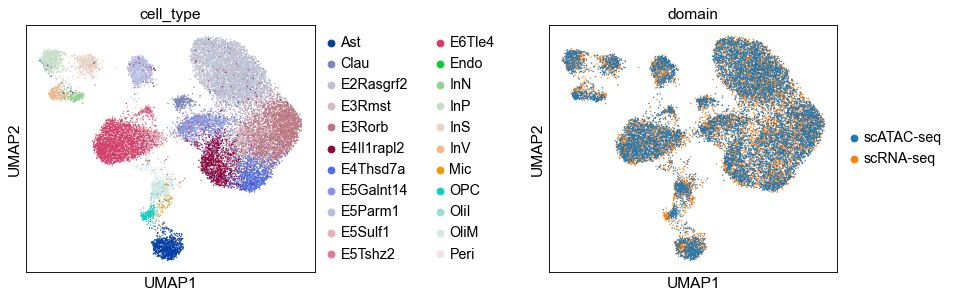

In [14]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

To obtain feature embeddings, we can use the [encode_graph](api/scglue.models.scglue.SCGLUEModel.encode_graph.rst) method.

In [15]:
feature_embeddings = glue.encode_graph(graph, edge_weight="weight", edge_sign="sign")
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,-0.039832,0.415630,0.002058,0.000609,0.000405
0610025J13Rik,0.159552,-0.051080,0.009581,0.000262,0.000372
1110002J07Rik,-0.417852,-0.503436,0.011497,0.000769,-0.005243
1110006O24Rik,-0.176432,0.570271,0.014452,0.009071,-0.001555
1110020A21Rik,0.585160,0.151869,0.004320,-0.003026,-0.008153


For regulatory inference based on the feature embeddings, please refer to our [case study](https://github.com/gao-lab/GLUE/blob/master/experiments/RegInf/s03_peak_gene_validation.ipynb).